<a href="https://colab.research.google.com/github/hasnainhawlader/Adapting-CLIP-for-Medical-Anomaly-Detection/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install --quiet kagglehub
!pip install --quiet open_clip_torch
!pip install --quiet torch torchvision matplotlib scikit-learn

In [50]:
import kagglehub
import os

# Download dataset

In [51]:
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
normal_dir = os.path.join(path, "no")
tumor_dir = os.path.join(path, "yes")

Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.


In [52]:
print("✅ Dataset downloaded.")
print("Normal images:", len(os.listdir(normal_dir)))
print("Tumor images:", len(os.listdir(tumor_dir)))

✅ Dataset downloaded.
Normal images: 98
Tumor images: 155


In [53]:
import open_clip
import torch
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load CLIP model

In [28]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [29]:
def encode_image(image_path):
    """Encodes a single image into a normalized CLIP feature vector."""
    image = Image.open(image_path).convert("RGB")
    # Preprocess the image and add a batch dimension (unsqueeze(0))
    image_input = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        # Encode the image using the visual transformer
        image_features = model.encode_image(image_input)
        # L2-normalize the features
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Return the feature vector as a flat NumPy array
    return image_features.cpu().numpy().flatten()

# --- 1. Extract features for Normal (Non-Tumor) images ---
# This block is correctly un-indented from the function definition

In [30]:
normal_features = []
for f in os.listdir(normal_dir):
    if not f.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    try:
        feat = encode_image(os.path.join(normal_dir, f))
        if not np.isnan(feat).any():
            normal_features.append(feat)
    except Exception as e:
        print(f"Skipped: {f}, Error: {e}")

In [31]:
if not normal_features:
    raise ValueError("No normal features extracted. Check dataset structure and image loading.")

# --- 2. Create the Reference Vector ---
# The reference vector is the mean feature vector of all normal images.

In [32]:
ref_vector = np.mean(normal_features, axis=0).reshape(1, -1)
print("✅ Reference vector created.")

✅ Reference vector created.


# --- 3. Extract features for Test (Normal + Tumor) images ---

In [33]:
test_features = []
labels = []

0 for Normal, 1 for Tumor

In [34]:
for cls_dir, label in [(normal_dir, 0), (tumor_dir, 1)]:
    for f in os.listdir(cls_dir):
        if not f.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        try:
            feat = encode_image(os.path.join(cls_dir, f))
            if not np.isnan(feat).any():
                test_features.append(feat)
                labels.append(label)
        except Exception as e:
            print(f"Skipped: {f}, Error: {e}")

In [35]:
if not test_features:
    raise ValueError("No test features extracted. Check dataset structure and image loading.")

# --- 4. Calculate Cosine Distance for Anomaly Detection ---

In [36]:
test_features = np.array(test_features).reshape(len(test_features), -1)

# Cosine Similarity is a measure of feature alignment.

In [39]:
similarities = cosine_similarity(test_features, ref_vector).flatten()

# Cosine Distance (Anomaly Score) is 1 - Similarity.
# A higher distance indicates a greater deviation from the "normal" reference vector.

In [40]:
distances = 1 - similarities

# --- 5. Plot the Results ---

In [41]:
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

# Separate the distances based on their true labels (Normal=0, Tumor=1)

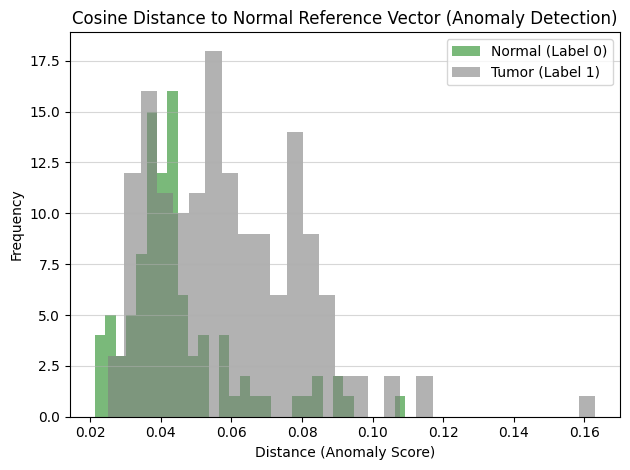

In [49]:
normal_distances = [distances[i] for i in range(len(distances)) if labels[i] == 0]
tumor_distances = [distances[i] for i in range(len(distances)) if labels[i] == 1]

plt.hist(normal_distances, bins=30, alpha=0.6, label='Normal (Label 0)', color = 'forestgreen')
plt.hist(tumor_distances, bins=30, alpha=0.6, label='Tumor (Label 1)', color='gray')

plt.title("Cosine Distance to Normal Reference Vector (Anomaly Detection)")
plt.xlabel("Distance (Anomaly Score)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()